In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 

%matplotlib inline

nCellls = 6

def dispHistAndGauss(ax, data):

    n_bins = int(np.sqrt(data.size))
    bin_size = (np.max(data) - np.min(data))/n_bins

    histCounts, edges, _ = ax.hist(data, bins = n_bins)
    binCenters = (edges[1:] + edges[:-1])/2

    gaussFunc = lambda x, A, mu, sig: A*np.exp(-(x-mu)**2/sig**2/2)
    mu = np.mean(data)
    sig = np.std(data, ddof=1)
    A = data.size/(np.sqrt(2*np.pi)*sig)*bin_size
    p0 = (A, mu, sig)

    print(data.shape)
    (A, mu, sig), _ = curve_fit(gaussFunc, binCenters, histCounts , p0=p0)

    x_gauss = np.linspace(np.min(data), np.max(data), 4*n_bins)
    y_gauss = gaussFunc(x_gauss, A, mu, sig)

    ax.plot(x_gauss, y_gauss, "r", label="$\sigma={:.2e}$\n$\mu={:.2e}$".format(sig, mu))
    ax.set_xlabel("$(\\tilde{E}_{ecs} - E_{ecs})/E_0$")
    ax.legend()


def doEscAnalysis(ax1,ax2, x, y):

    a, b = np.polyfit(x, y, 1)
    pred_y = a*x+b
    
    deflection_y = y - pred_y
    
    n_bins = int(np.sqrt(x.size))
    bin_size = (np.max(deflection_y) - np.min(deflection_y))/n_bins


    ax1.scatter(x, y, s=0.5)
    ax1.plot(x, pred_y, "r")
    ax1.set_xlabel("$E_{dep}/E_0$")
    ax1.set_ylabel("$E_{ecs}/E_0$")


    histCounts, edges, _ = ax2.hist(deflection_y, bins= n_bins )
    binCenters = (edges[1:] + edges[:-1])/2

    gaussFunc = lambda x, A, mu, sig: A*np.exp(-(x-mu)**2/sig**2/2)
    mu = np.mean(deflection_y)
    sig = np.std(deflection_y, ddof=1)
    A = deflection_y.size/(np.sqrt(2*np.pi)*sig)*bin_size
    p0 = (A, mu, sig)

    (A, mu, sig), _ = curve_fit(gaussFunc, binCenters, histCounts , p0=p0)

    x_gauss = np.linspace(np.min(deflection_y), np.max(deflection_y), 4*n_bins)
    y_gauss = gaussFunc(x_gauss, A, mu, sig)

    ax2.plot(x_gauss, y_gauss, "r", label="$\sigma={:.2e}$".format(sig))
    ax2.set_xlabel("$(E_{ecs} - \\tilde{E}_{ecs})/E_0$")
    ax2.legend()




def drawEscapePlots(rootFileTitle, particle, energy, xinit, yinit):


    treeEsc = uproot.open(f"{rootFileTitle}_{particle}_{energy}GeV_{xinit},{yinit}.root")["Eecs"]
    df_Ecs = treeEsc.arrays(library="np")

    treeEdep = uproot.open(f"{rootFileTitle}_{particle}_{energy}GeV_{xinit},{yinit}.root")["Edep"]
    df_Dep = treeEdep.arrays(library="np")


    cellsEscEventWise = []
    cellsDepEventWise = []

    for cellID in range(nCellls):
        cellsEscEventWise.append( np.zeros((np.max(df_Dep["evntID"])+1,)) )
        cellsDepEventWise.append( np.zeros((np.max(df_Dep["evntID"])+1,)) )

    for i in range(df_Ecs["evntID"].size):

        evntID = df_Ecs["evntID"][i]
        cellID = df_Ecs["cellID"][i]

        cellsEscEventWise[cellID][evntID] += df_Ecs["escE"][i]

    for i in range(df_Dep["evntID"].size):

        evntID = df_Dep["evntID"][i]
        cellID = df_Dep["cellID"][i]

        cellsDepEventWise[cellID][evntID] += df_Dep["eDep_cell"][i]

    for cellID in range(nCellls):

        cellsEscEventWise[cellID]/=energy*1000
        cellsDepEventWise[cellID]/=energy*1000


    #############################################
    ## Calculate total values
    #############################################    

    totEscaped = np.zeros_like(cellsEscEventWise[0])
    totDeposited = np.zeros_like(cellsDepEventWise[0])

    for cellID in range(nCellls):

        totEscaped += cellsEscEventWise[cellID]
        totDeposited += cellsDepEventWise[cellID]

    print("Mean escaped =", np.mean(totEscaped)*energy*1000)
    print("Mean deposited =", np.mean(totDeposited)*energy*1000)

    #############################################
    ## Plot Figures
    #############################################

    fig, ax = plt.subplots(3,2, figsize=(2*6.4*1.2, 3*4.8*1.2))


    doEscAnalysis(ax[0, 0], ax[0, 1], cellsDepEventWise[cellID], cellsEscEventWise[cellID])
    ax[0,0].set_title(f"{energy} GeV {particle}. X = {xinit} Y = {yinit}. Cell number {5}")
    ax[0,1].set_title(f"{energy} GeV {particle}. X = {xinit} Y = {yinit}. Cell number {5}")


    doEscAnalysis(ax[1, 0], ax[1, 1], totDeposited, totEscaped)
    ax[1, 0].set_title(f"{energy} GeV {particle}. X = {xinit} Y = {yinit}. Whole calorimeter")
    ax[1, 1].set_title(f"{energy} GeV {particle}. X = {xinit} Y = {yinit}. Whole calorimeter")

    #############################################
    ## Grid of sells
    #############################################

    x_grd1 = np.array([-84,84])
    x_grd1 = x_grd1[np.newaxis, :]
    x_grd1 = np.repeat(x_grd1, 2, axis=0)

    x_grd2 = np.linspace(-84, 84,7)
    x_grd2 = x_grd2[:, np.newaxis]
    x_grd2 = np.repeat(x_grd2, 2, axis=1)

    x_grd = np.concatenate((x_grd1, x_grd2))


    y_grd1 = np.linspace(-84, 84,2)
    y_grd1 = y_grd1[:, np.newaxis]
    y_grd1 = np.repeat(y_grd1, 2, axis=1)

    y_grd2 = np.array([-84,84])
    y_grd2 = y_grd2[np.newaxis, :]
    y_grd2 = np.repeat(y_grd2, 7, axis=0)

    y_grd = np.concatenate((y_grd1, y_grd2))


    for cellID in range(nCellls+3): 
        ax[2, 0].plot(x_grd[cellID], y_grd[cellID], "k")

    for cellID in range(nCellls): 

        x = (cellID*28.0-70)
        y = 14.0

        ax[2, 0].text(x, y, f"{cellID}", transform=ax[2, 0].transData)
        ax[2, 0].axis('equal')

    ax[2, 0].set_xlabel("x [mm]")
    ax[2, 0].set_ylabel("y [mm]")
    ax[2, 0].plot([xinit], [yinit], "+r", label=f"{particle} entry point\nx={xinit} mm\ny={yinit} mm")
    ax[2, 0].set_title("Cells numbering")
    ax[2, 0].legend(frameon=True, loc='center', bbox_to_anchor=(0.4, 0.3))

    #############################################
    ## Eesc of last cell
    #############################################

    dispHistAndGauss(ax[2, 1], cellsEscEventWise[5])
    ax[2, 1].set_xlabel("$E_{esc}/E_0$")
    ax[2, 1].set_title(f"{energy} GeV {particle}. X = {xinit} Y = {yinit}."+" $E_{esc}$ from edge of the cell number 5")


    fig.savefig(f"plots/Energy_escaping_Cell_analysis_{energy}_GeV_{particle}_x={xinit}_y={yinit}.png")


Mean escaped = 594.234059227954
Mean deposited = 24314.59491844113
(1000,)


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Mean escaped = 611.6633633855009
Mean deposited = 24295.50505927964
(1000,)


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Mean escaped = 629.242942317228
Mean deposited = 24276.346152514907
(1000,)


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Mean escaped = 676.4340131455415
Mean deposited = 24229.638522158853
(1000,)


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Mean escaped = 729.0846626827337
Mean deposited = 24174.94664183127
(1000,)


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Mean escaped = 821.4398395717992
Mean deposited = 24079.347226134367
(1000,)


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Mean escaped = 964.8149159280106
Mean deposited = 23937.29503604054


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(1000,)
Mean escaped = 1159.3812918912372
Mean deposited = 23740.094505925474
(1000,)


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Mean escaped = 1462.2835736669626
Mean deposited = 23436.05108332867
(1000,)


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Mean escaped = 2013.1783561960717
Mean deposited = 22884.61673353652
(1000,)


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Mean escaped = 3142.431482547599
Mean deposited = 21766.225086296385
(1000,)


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Mean escaped = 6893.764531755285
Mean deposited = 18095.880032271158
(1000,)


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


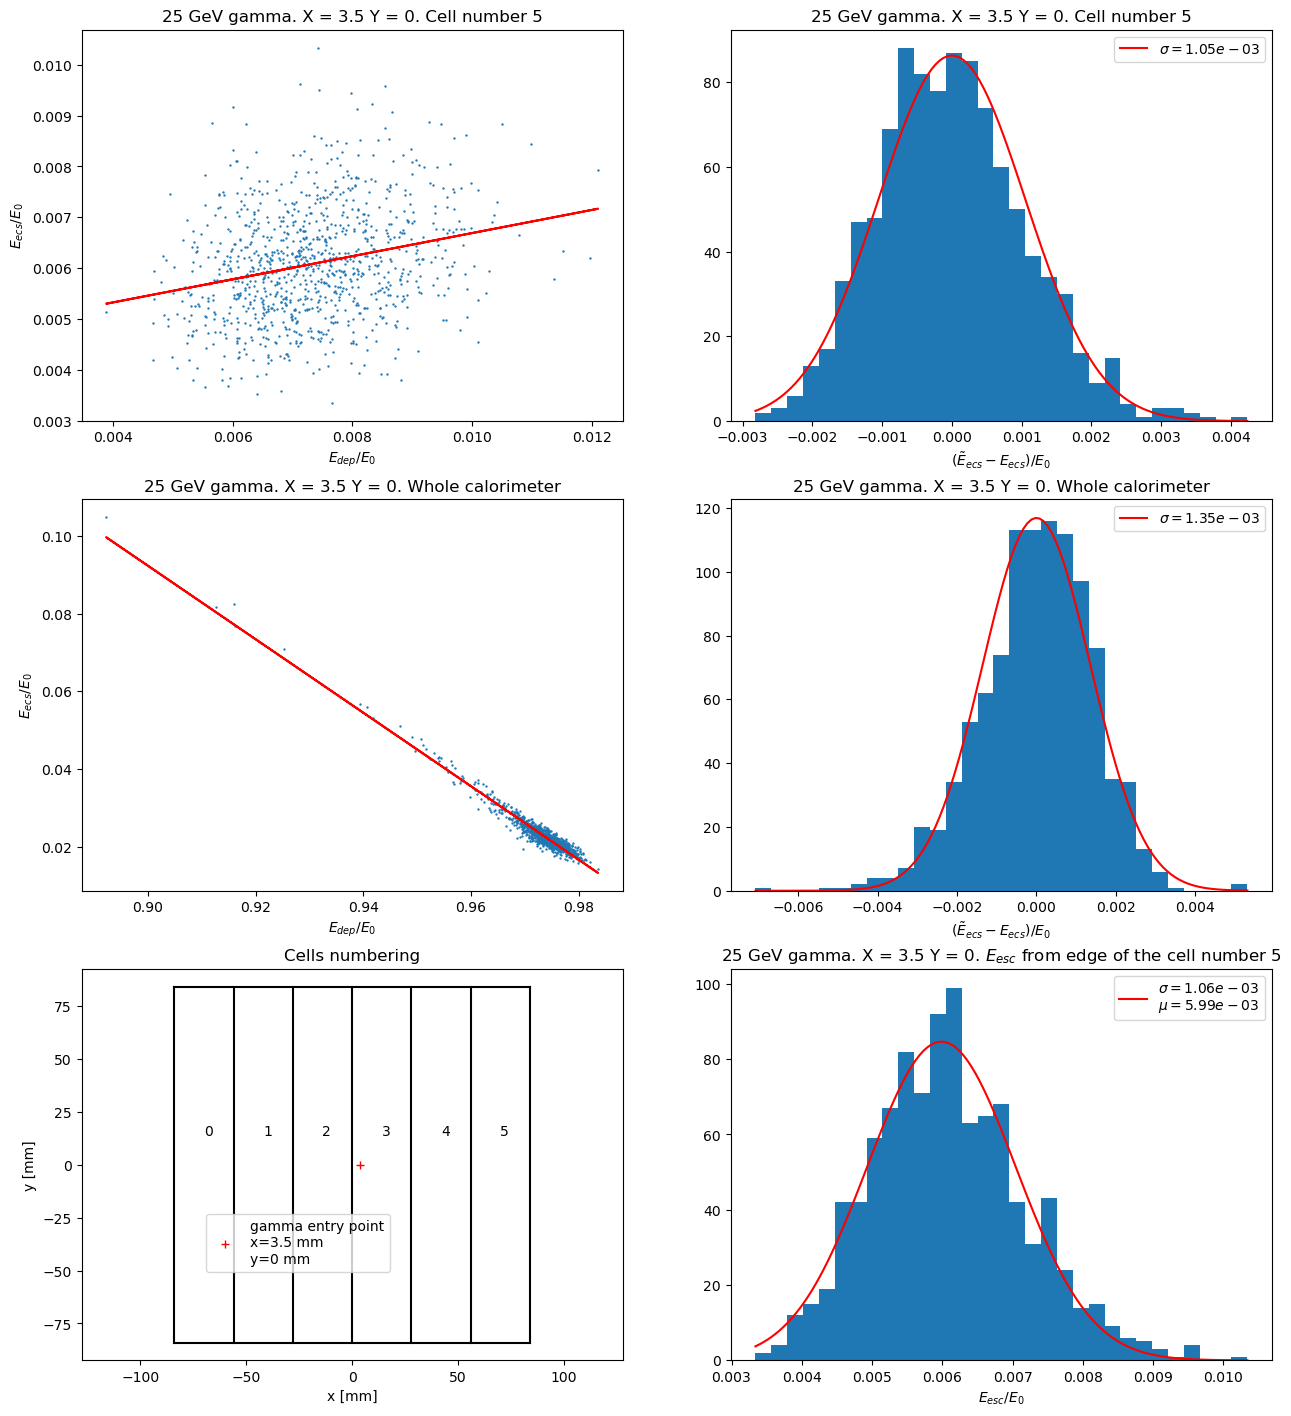

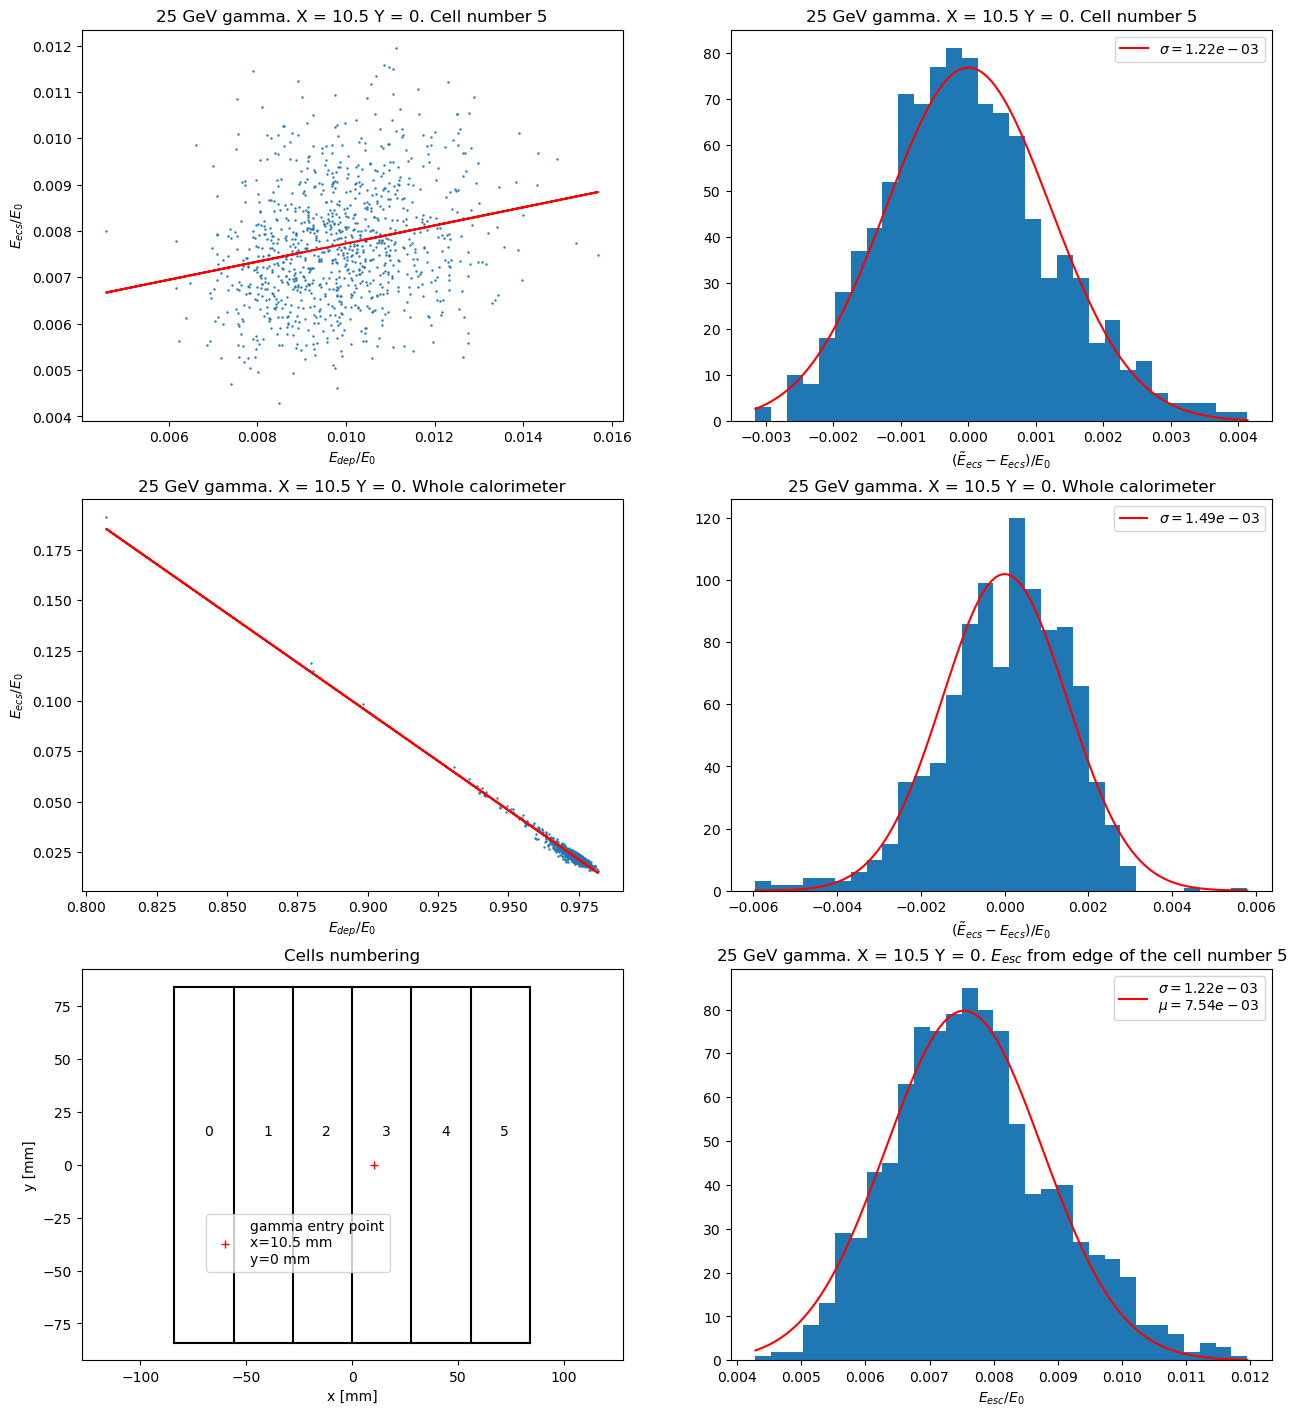

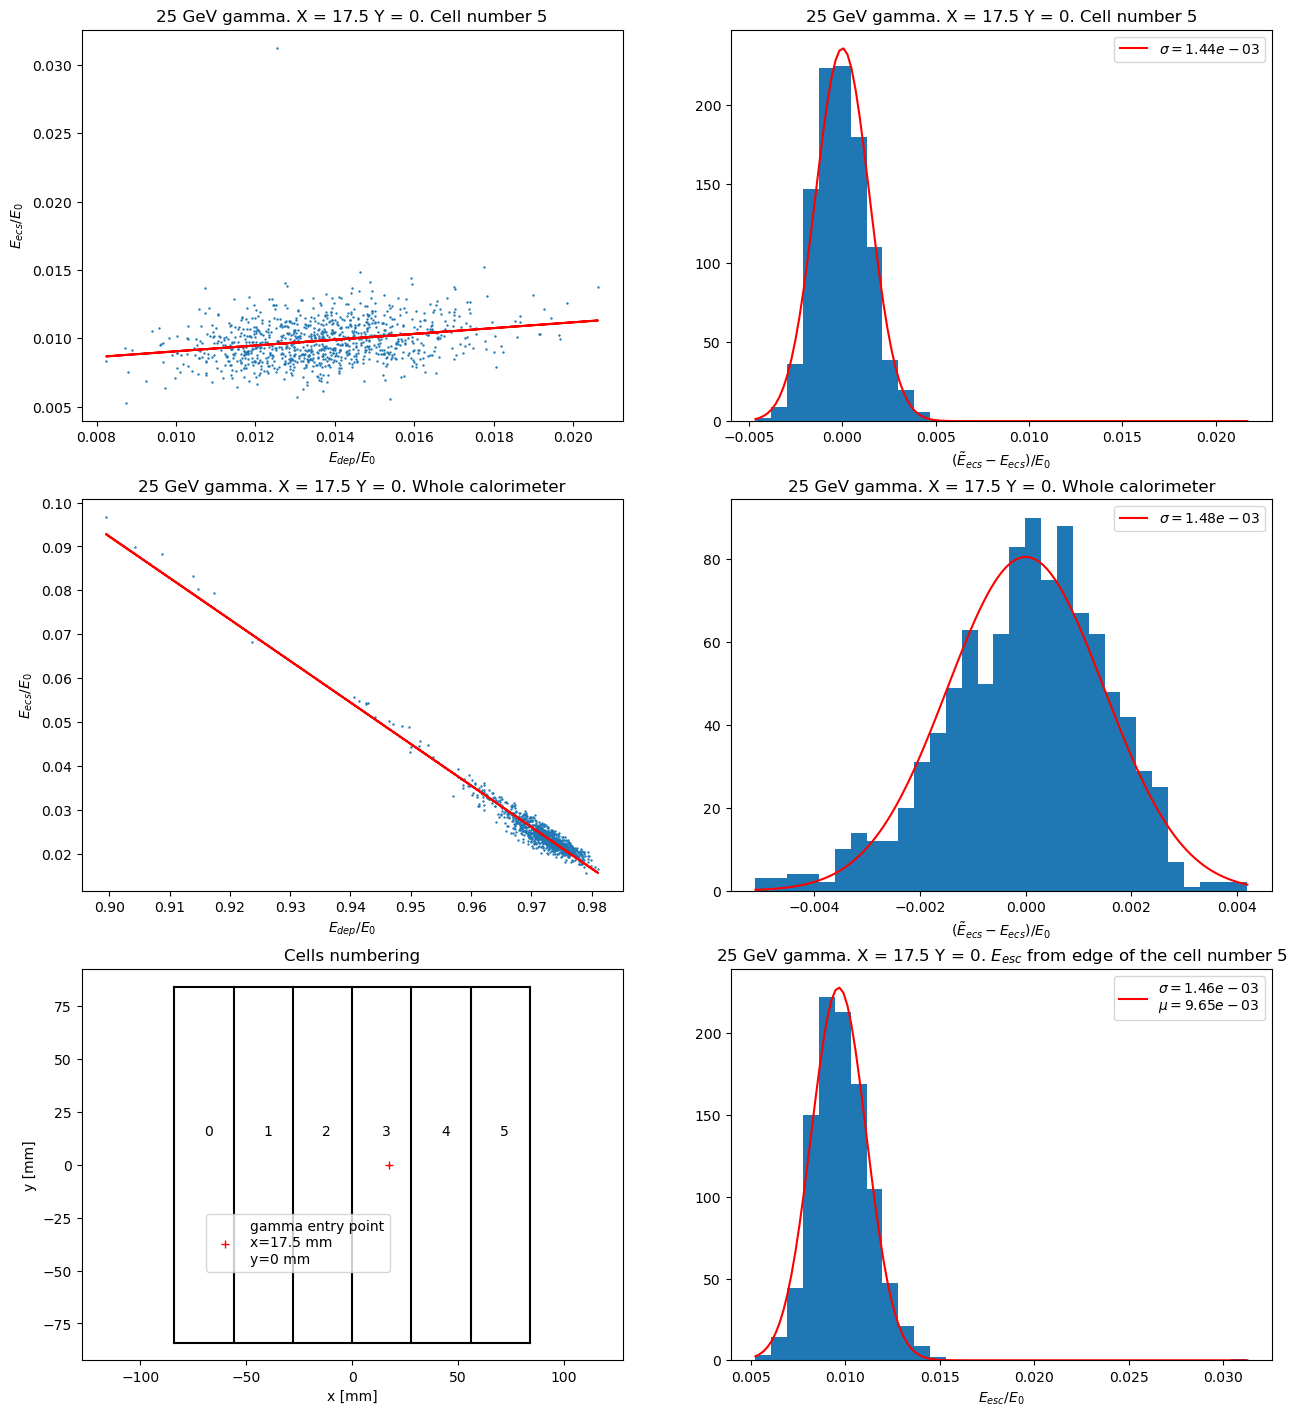

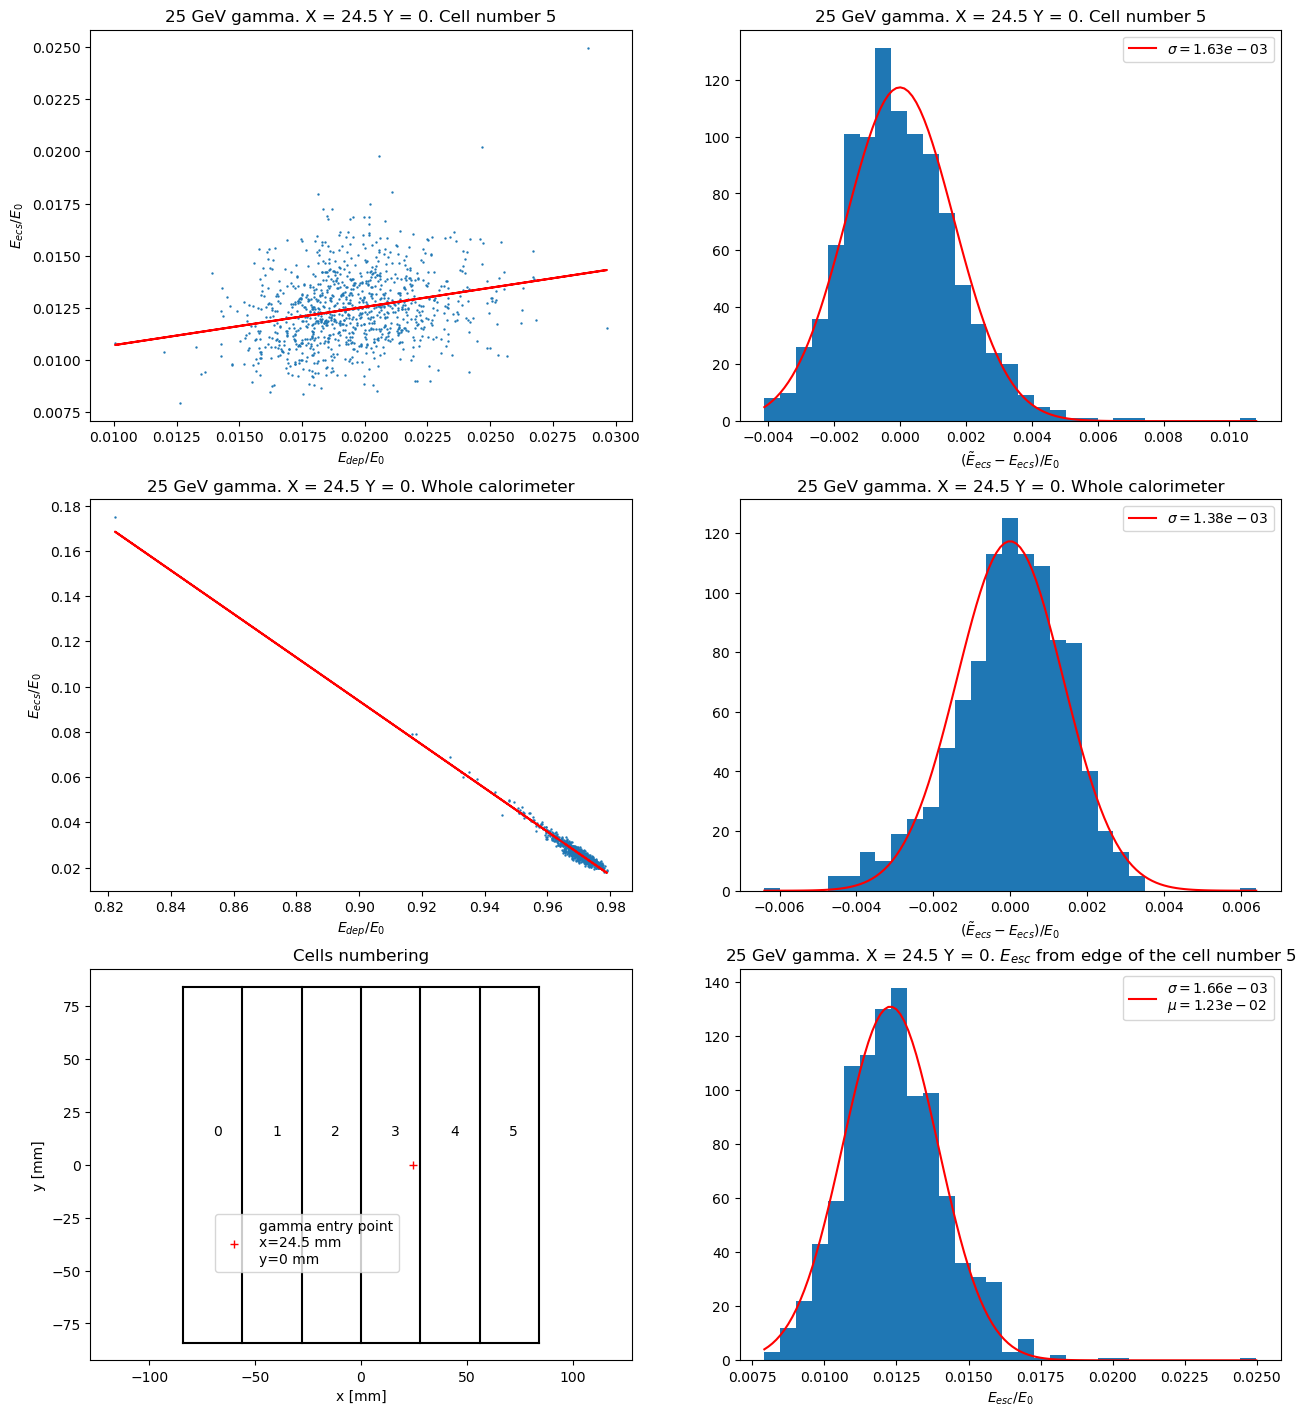

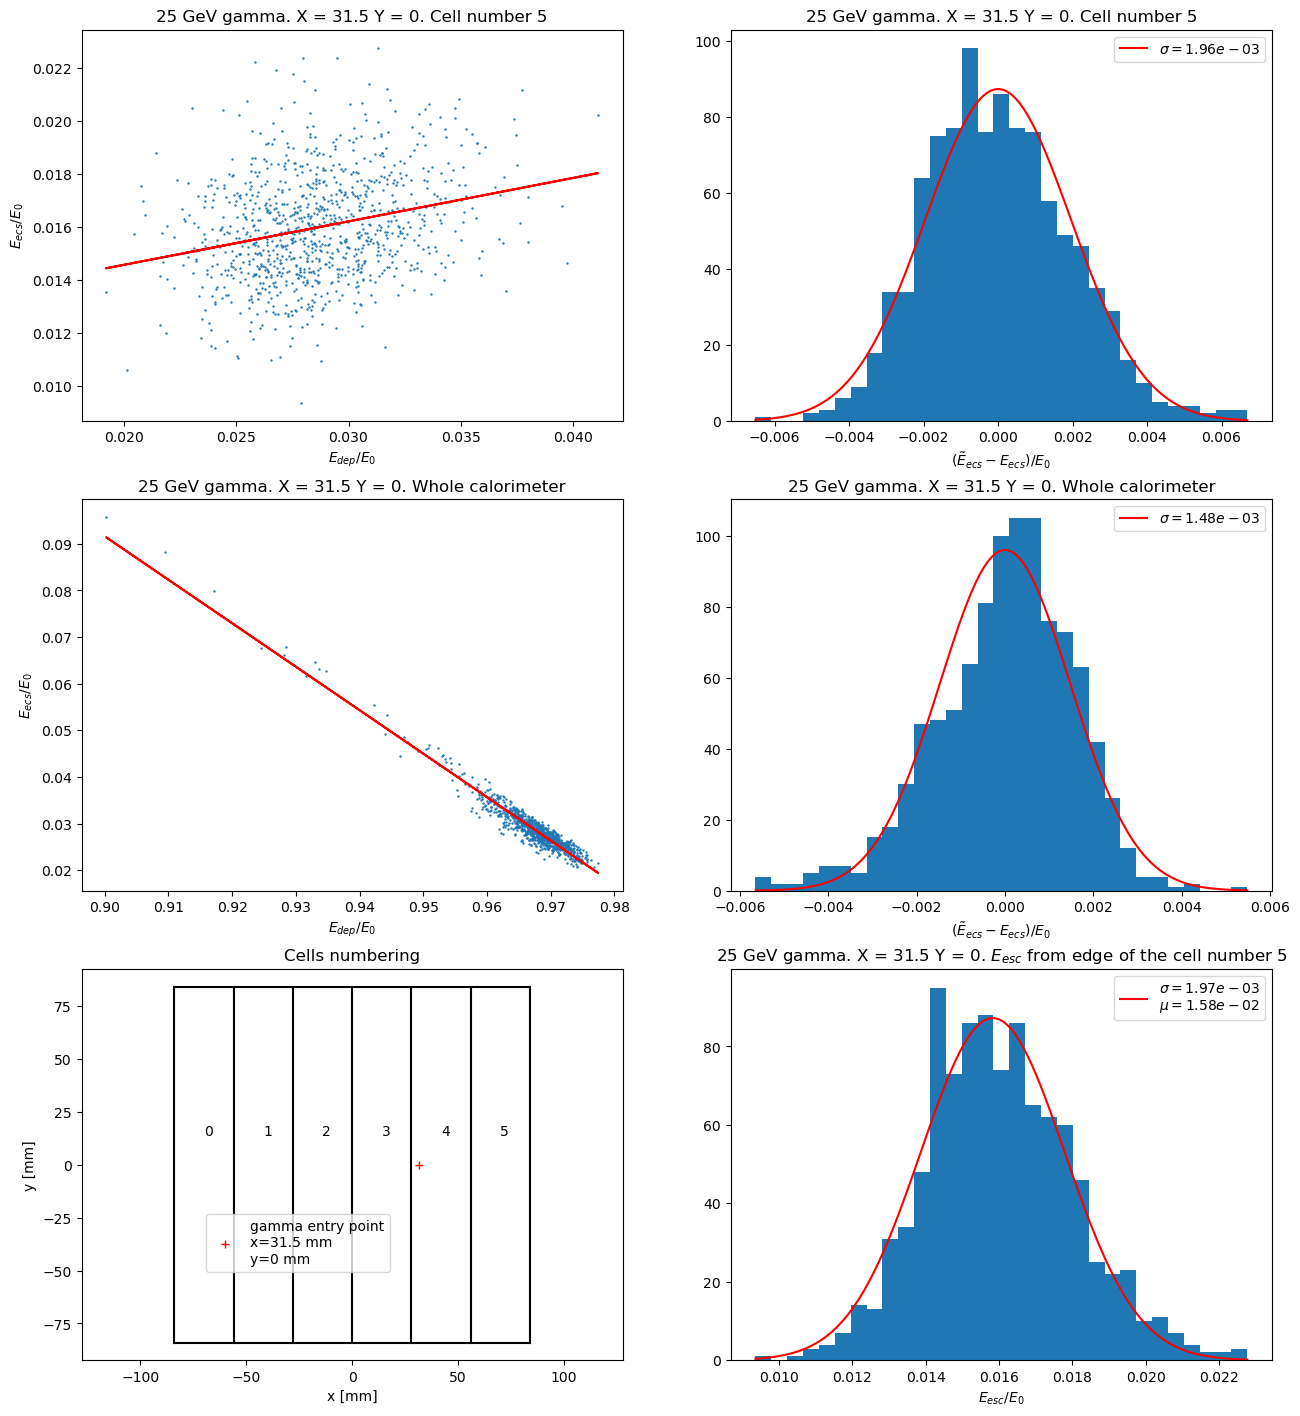

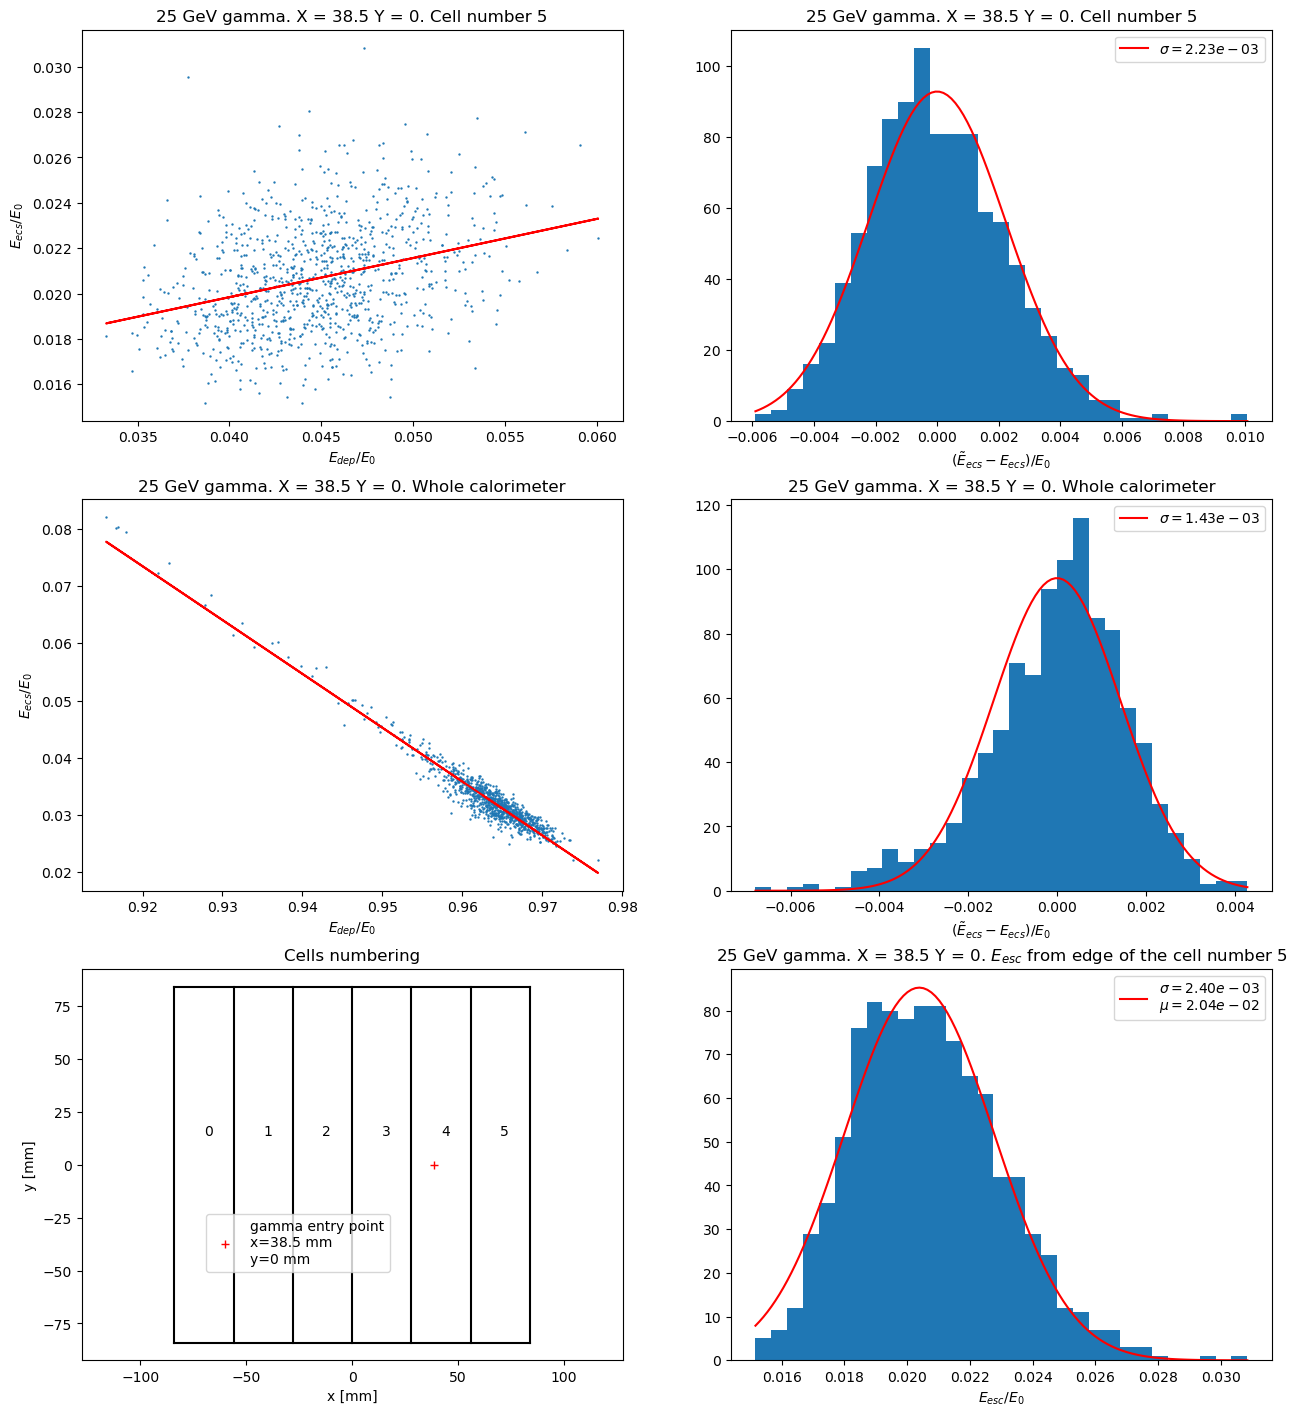

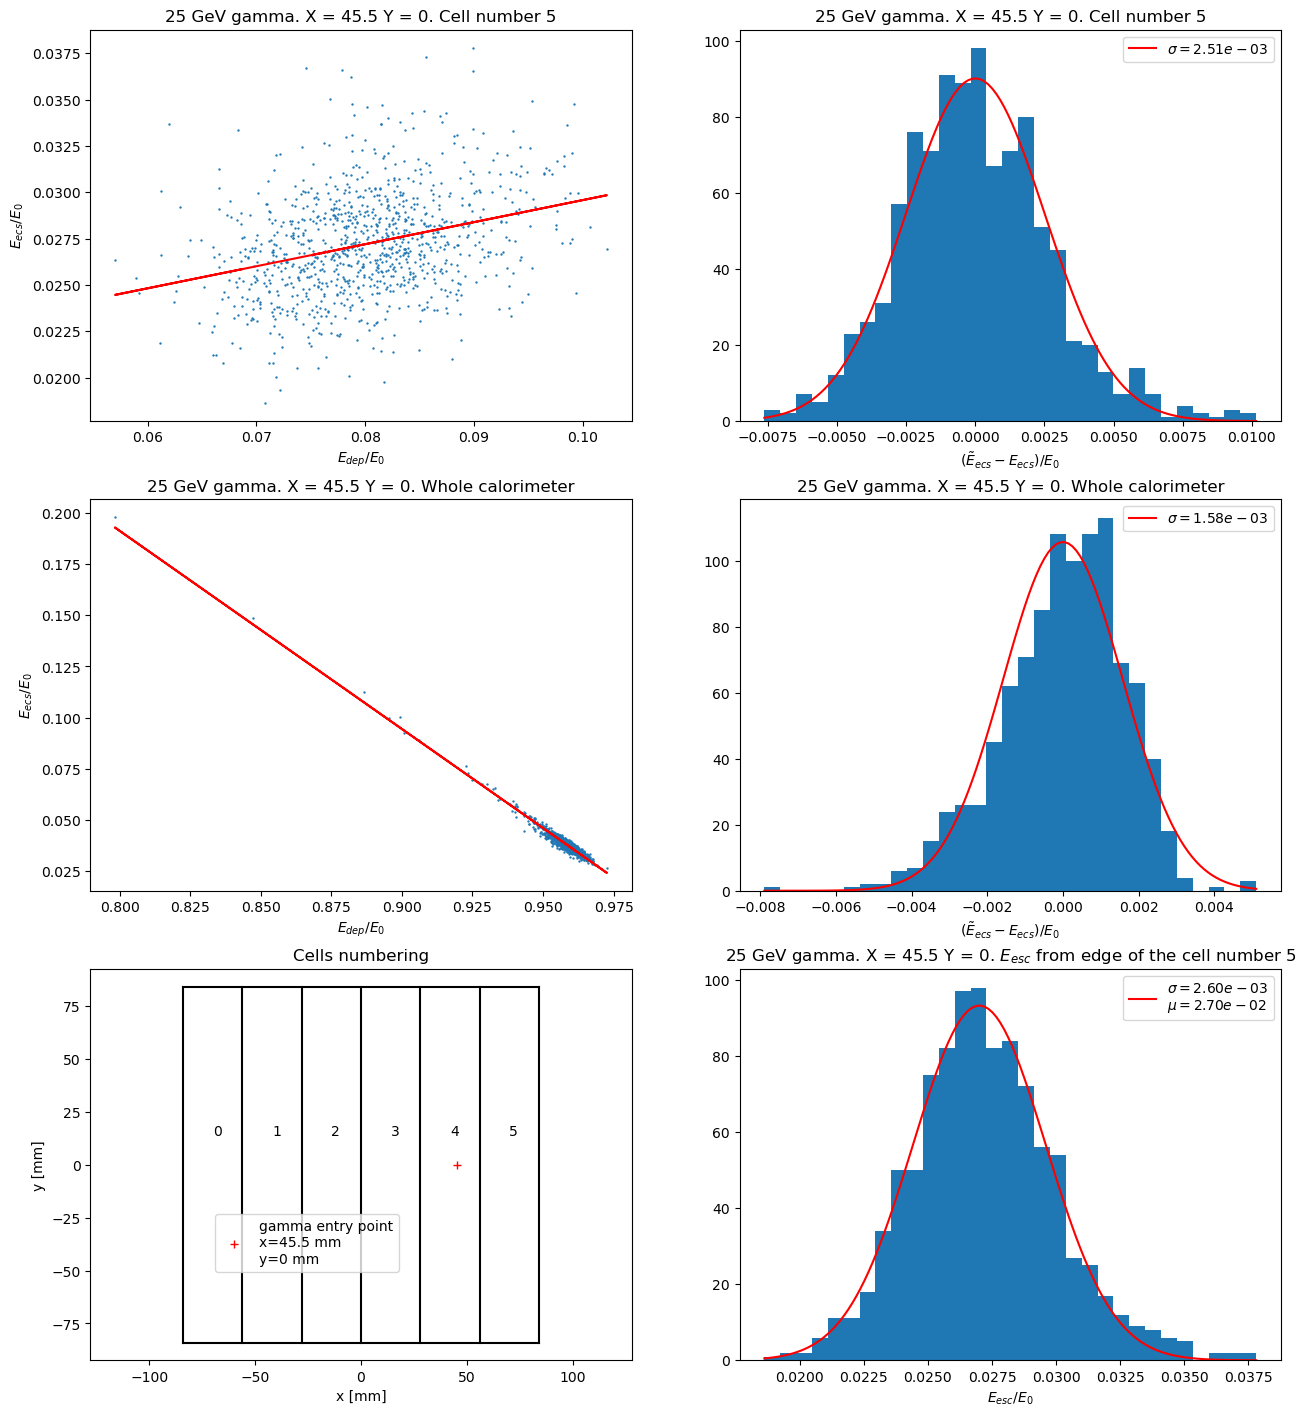

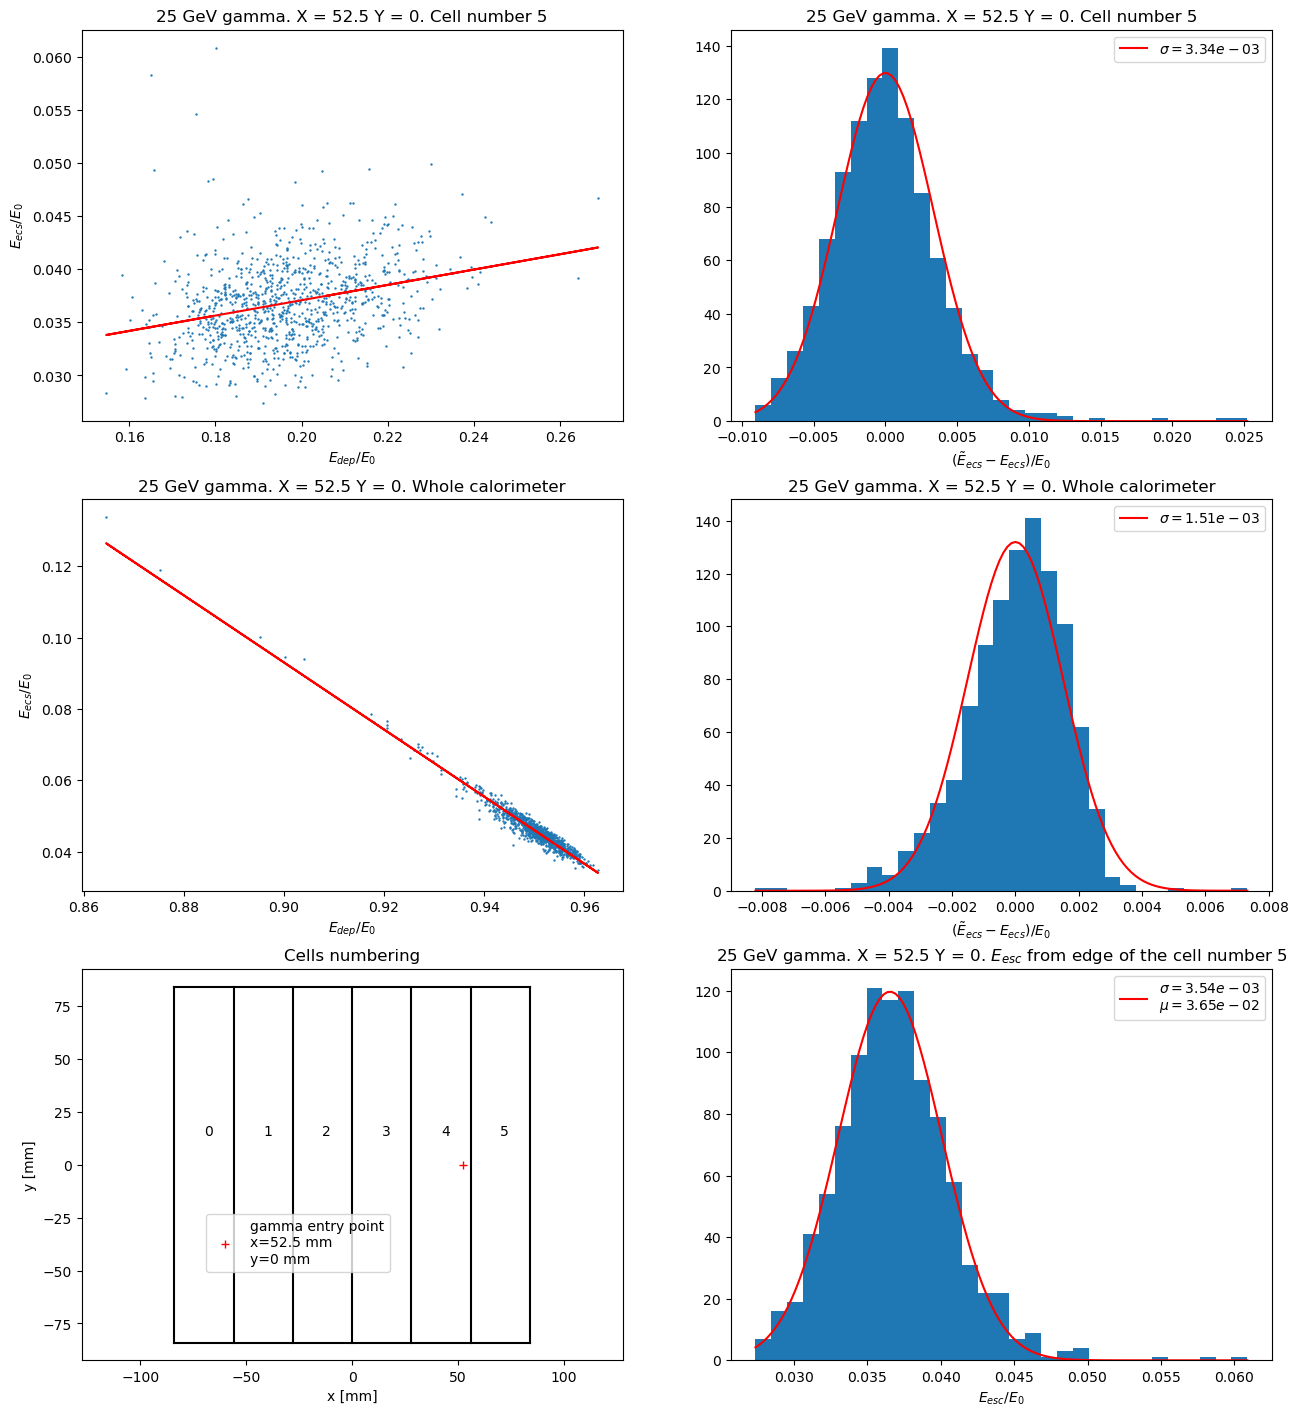

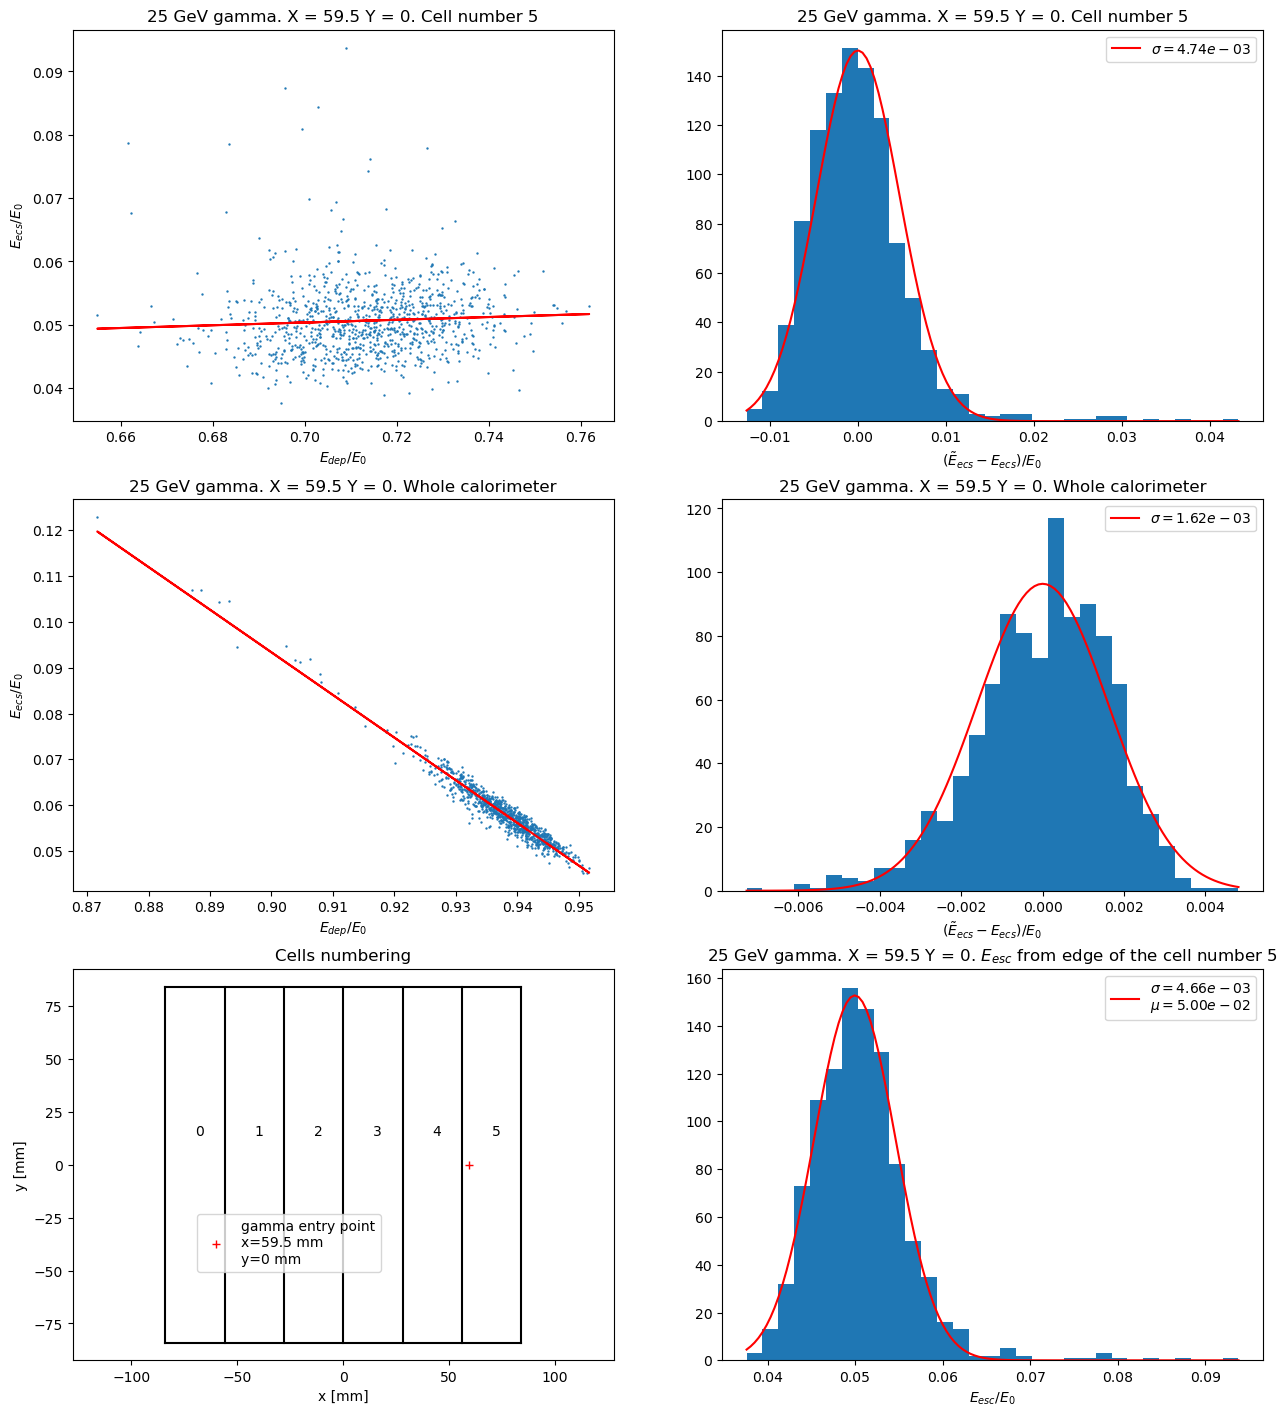

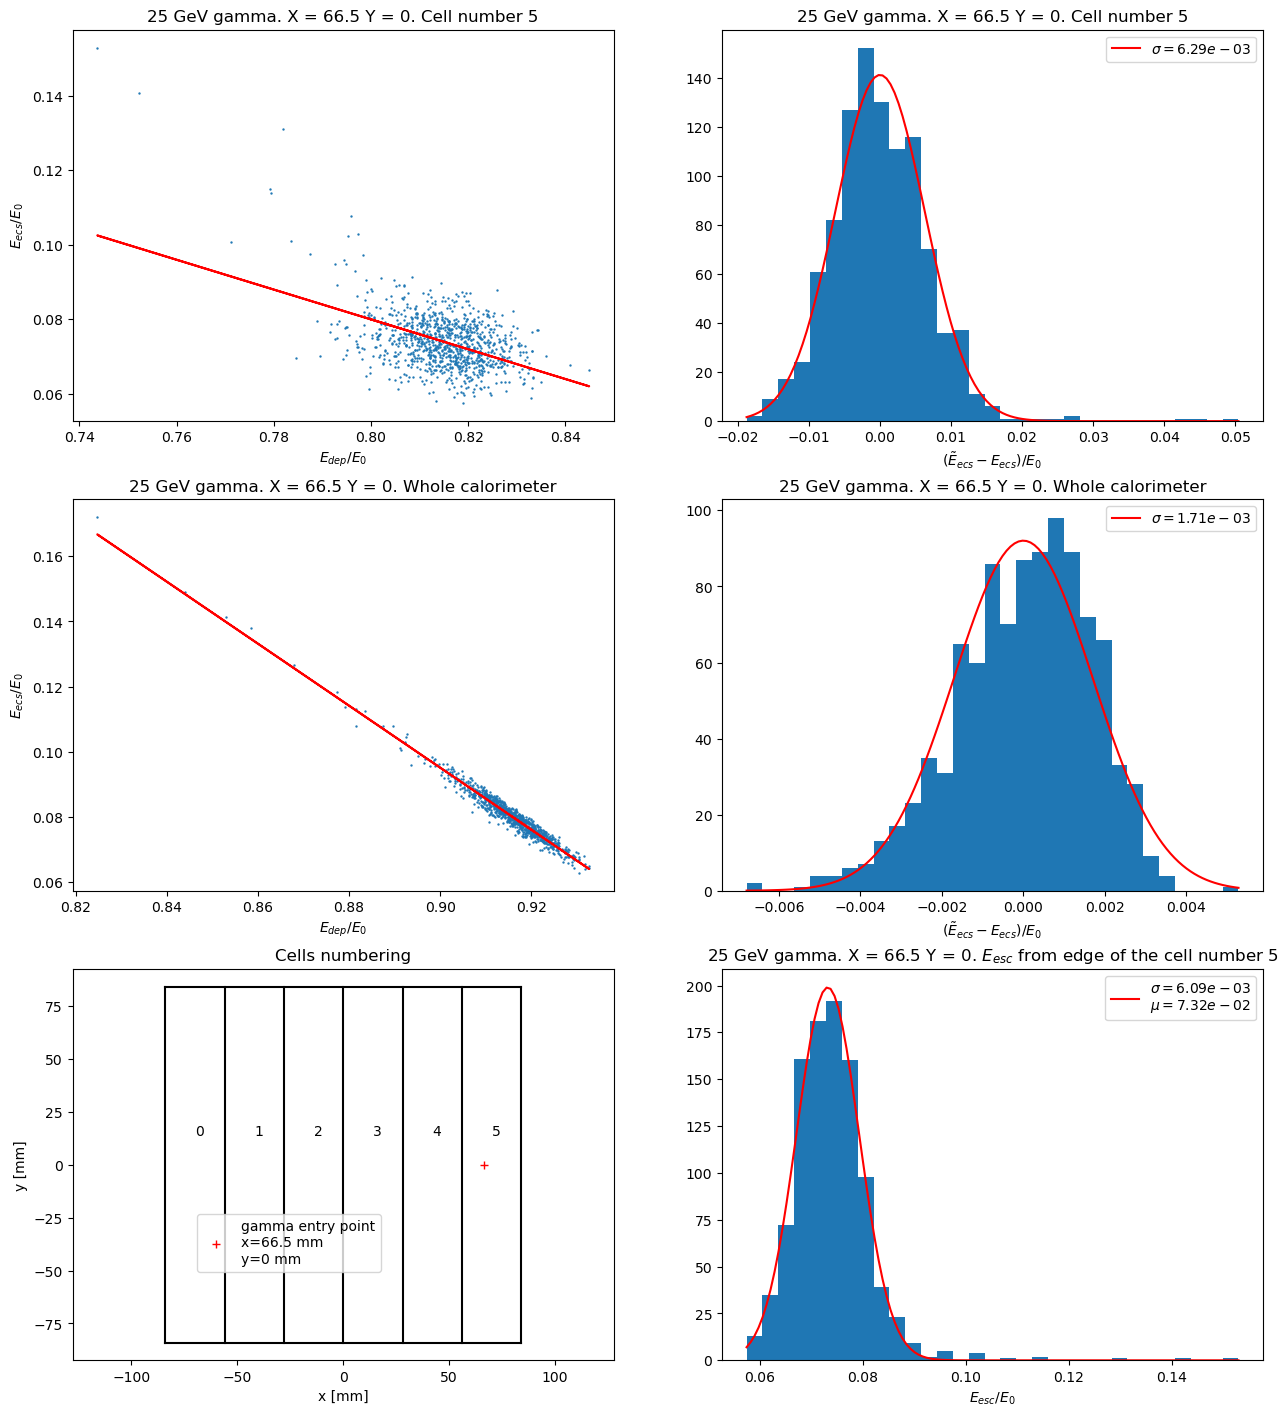

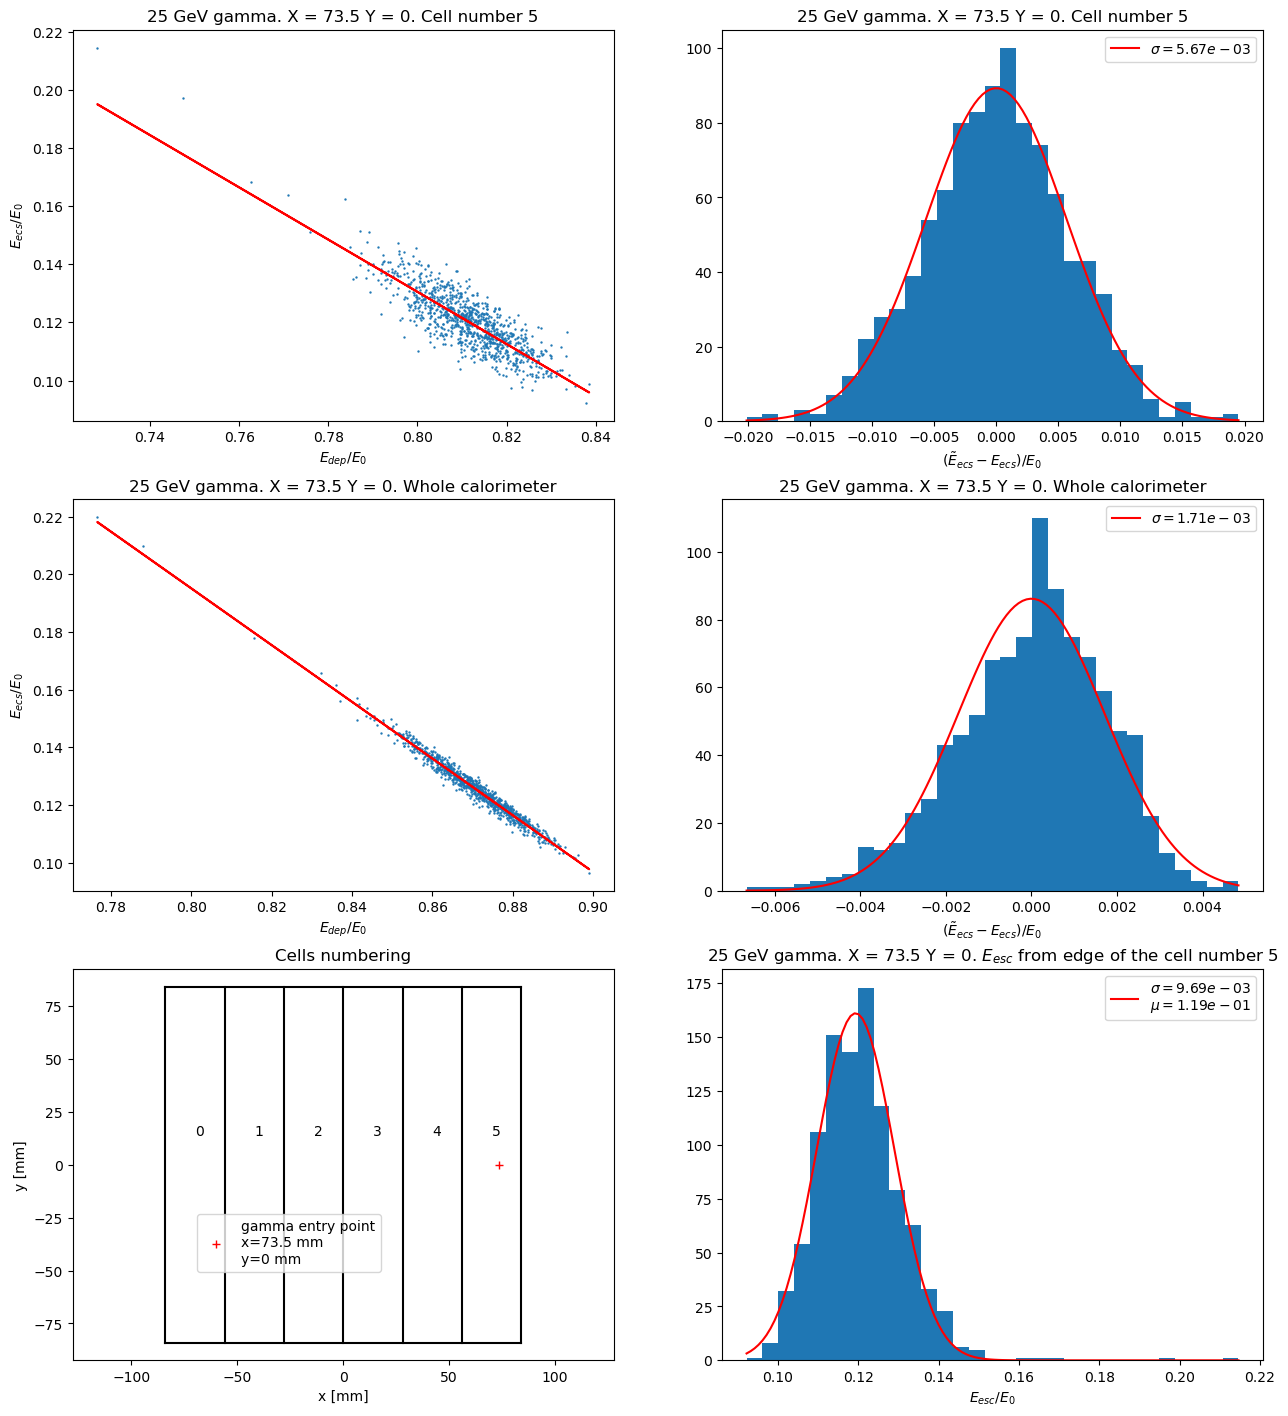

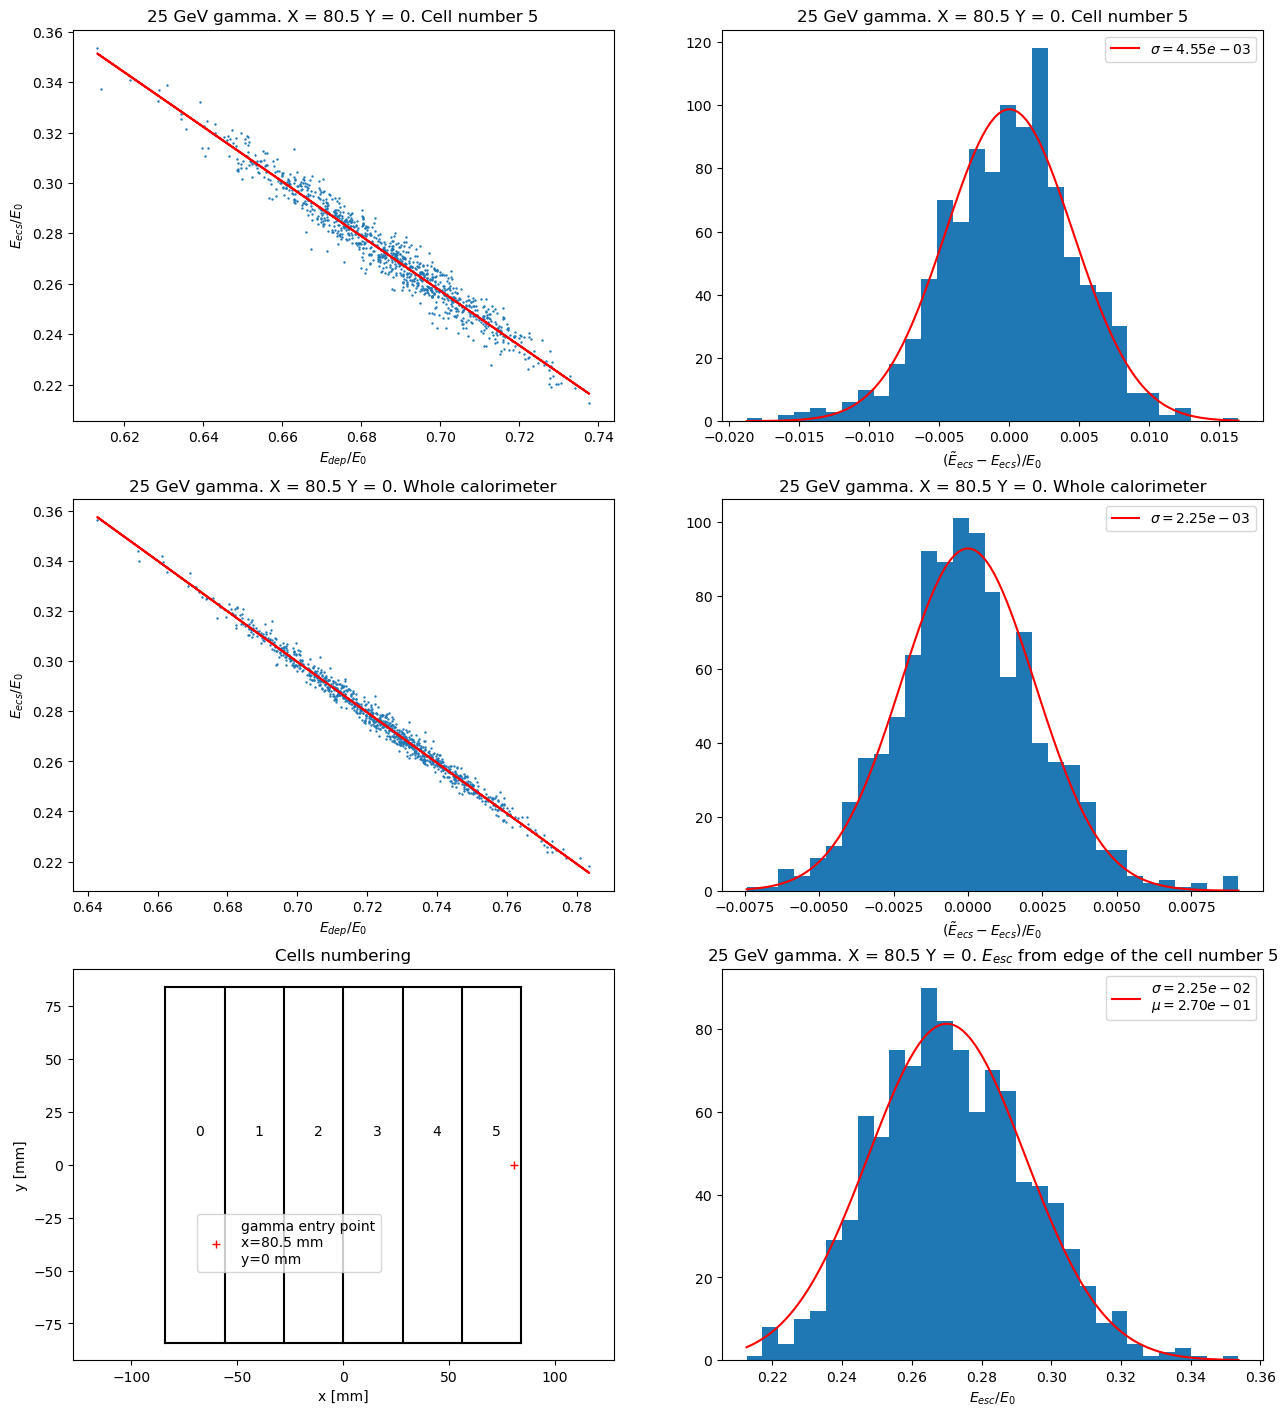

In [2]:
drawEscapePlots("build/eEsc", "gamma", 25,  3.5, 0)
drawEscapePlots("build/eEsc", "gamma", 25, 10.5, 0)
drawEscapePlots("build/eEsc", "gamma", 25, 17.5, 0)
drawEscapePlots("build/eEsc", "gamma", 25, 24.5, 0)
drawEscapePlots("build/eEsc", "gamma", 25, 31.5, 0)
drawEscapePlots("build/eEsc", "gamma", 25, 38.5, 0)
drawEscapePlots("build/eEsc", "gamma", 25, 45.5, 0)
drawEscapePlots("build/eEsc", "gamma", 25, 52.5, 0)
drawEscapePlots("build/eEsc", "gamma", 25, 59.5, 0)
drawEscapePlots("build/eEsc", "gamma", 25, 66.5, 0)
drawEscapePlots("build/eEsc", "gamma", 25, 73.5, 0)
drawEscapePlots("build/eEsc", "gamma", 25, 80.5, 0)

In [3]:
# drawEscapePlots("build/eEsc", "gamma", 1,  3.5, 0)
# drawEscapePlots("build/eEsc", "gamma", 1, 10.5, 0)
# drawEscapePlots("build/eEsc", "gamma", 1, 17.5, 0)
# drawEscapePlots("build/eEsc", "gamma", 1, 24.5, 0)
# drawEscapePlots("build/eEsc", "gamma", 1, 31.5, 0)
# drawEscapePlots("build/eEsc", "gamma", 1, 38.5, 0)
# drawEscapePlots("build/eEsc", "gamma", 1, 45.5, 0)
# drawEscapePlots("build/eEsc", "gamma", 1, 52.5, 0)
# drawEscapePlots("build/eEsc", "gamma", 1, 59.5, 0)
# drawEscapePlots("build/eEsc", "gamma", 1, 66.5, 0)
# drawEscapePlots("build/eEsc", "gamma", 1, 73.5, 0)
# drawEscapePlots("build/eEsc", "gamma", 1, 80.5, 0)